In [ ]:
#Importing Libraries
from __future__ import print_function, division
from builtins import range, input

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

In [ ]:
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b

In [ ]:
# Disabling eager execution in Tensorflow
import tensorflow as tf
if tf.__version__.startswith('2'):
  tf.compat.v1.disable_eager_execution()

In [ ]:
def VGG16_AvgPool(shape):
  # for features across the entire image
  # get rid of the maxpool which throws away information
  
  vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)

  i = vgg.input
  x = i
  for layer in vgg.layers:
    if layer.__class__ == MaxPooling2D:
      # replace it with average pooling
      x = AveragePooling2D()(x)
    else:
      x = layer(x)

  return Model(i, x)

In [ ]:
def VGG16_AvgPool_CutOff(shape, num_convs):
  # 13 convolutions in total
  # we can pick any of them as the "output"
  # of our content model

  if num_convs < 1 or num_convs > 13:
    print("num_convs must be in the range [1, 13]")
    return None

  model = VGG16_AvgPool(shape)

  n = 0
  output = None
  for layer in model.layers:
    if layer.__class__ == Conv2D:
      n += 1
    if n >= num_convs:
      output = layer.output
      break

  return Model(model.input, output)

In [ ]:
def unpreprocess(img):
  img[..., 0] += 103.939
  img[..., 1] += 116.779
  img[..., 2] += 126.68
  img = img[..., ::-1]
  return img

In [ ]:
def scale_img(x):
  x = x - x.min()
  x = x / x.max()
  return x

## **Phase-I - Content Reconstruction**

In [ ]:
path = '/content/cat.jpg'
img = image.load_img(path)

In [ ]:
img

In [ ]:
# convert image to array and preprocess for vgg
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [ ]:
batch_shape = x.shape
shape = x.shape[1:]

In [ ]:
batch_shape

(1, 363, 550, 3)

In [ ]:
shape

(363, 550, 3)

In [ ]:
# make a content model
content_model = VGG16_AvgPool_CutOff(shape,12)

# make the target
target = K.variable(content_model.predict(x))

In [ ]:
# define our loss in keras
loss = K.mean(K.square(target - content_model.output))

# gradients which are needed by the optimizer
grads = K.gradients(loss, content_model.input)


get_loss_and_grads = K.function(
  inputs=[content_model.input],
  outputs=[loss] + grads
)

# **Scipy Optimizer**

  ## Scipy's minimizer (optimizer) allows us to pass back
  ## function value f(x) and its gradient f'(x)
  ## simultaneously, rather than using the fprime arg
  ## we cannot use get_loss_and_grads() directly
  ## input to minimizer func must be a 1-D array
  ## input to get_loss_and_grads must be [batch_of_images]
  ## gradient must also be a 1-D array
  ## and both loss and gradient must be np.float64
  ## will get an error otherwise

In [ ]:
def get_loss_and_grads_wrapper(x_vec):
  l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
  return l.astype(np.float64), g.flatten().astype(np.float64)

In [ ]:
from datetime import datetime

t0 = datetime.now()
losses = []
x = np.random.randn(np.prod(batch_shape))
for i in range(30):
  x, l, _ = fmin_l_bfgs_b(
    func=get_loss_and_grads_wrapper,
    x0=x,
    # bounds=[[-127, 127]]*len(x.flatten()),
    maxfun=20
  )
  x = np.clip(x, -127, 127)
  # print("min:", x.min(), "max:", x.max())
  print("iter=%s, loss=%s" % (i, l))
  losses.append(l)

print("duration:", datetime.now() - t0)

In [ ]:
#Plotting Losses
plt.plot(losses)
plt.show()

In [ ]:
#Unpreprocess the final image after optimization
newimg = x.reshape(*batch_shape)
final_img = unpreprocess(newimg)

In [ ]:
#Plotting Final Content Image
plt.imshow(scale_img(final_img[0]))
plt.axis('off')
plt.show()

In [ ]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(12,10),dpi=80) 
 
plt.figure(1)
plt.subplot(121)
plt.imshow(scale_img(final_img[0]))
plt.axis('off')

plt.subplot(122)
plt.imshow(img)

plt.axis('off')
plt.show()

# **Phase - 2 - Style Optimization**

In [ ]:
#Statistically, an autocorrelation matrix to relate the image with itself to keep the essence of the image
def gram_matrix(img):
  # input is (H, W, C) (C = # feature maps)
  # we first need to convert it to (C, H*W)
  X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))
  # now, calculate the gram matrix
  # gram = XX^T / N
  # the constant is not important since we'll be weighting these
  G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements()
  return G

In [ ]:
#Define the Style Loss
def style_loss(y, t):
  return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))

In [ ]:
#Generalizing the Optimization process
def minimize_loss(fn, epochs, batch_shape):
  t0 = datetime.now()
  losses = []
  x = np.random.randn(np.prod(batch_shape))
  for i in range(epochs):
    x, l, _ = fmin_l_bfgs_b(
      func=fn,
      x0=x,
      maxfun=20
    )
    x = np.clip(x, -127, 127)
    print("iter=%s, loss=%s" % (i, l))
    losses.append(l)

  print("duration:", datetime.now() - t0)
  plt.plot(losses)
  plt.show()

  newimg = x.reshape(*batch_shape)
  final_img = unpreprocess(newimg)
  return final_img[0]

In [ ]:
 path = '/content/rain-princess.jpg'

In [ ]:
# load the data
img2 = image.load_img(path)

# convert image to array and preprocess for vgg
x = image.img_to_array(img2)

# make it (1, H, W, C)
x = np.expand_dims(x, axis=0)

# preprocess into VGG expected format
x = preprocess_input(x)

In [ ]:
img2

In [ ]:
batch_shape = x.shape
shape = x.shape[1:]

In [ ]:
batch_shape

(1, 1014, 1280, 3)

In [ ]:
shape

(1014, 1280, 3)

In [ ]:
# taking the first convolution at each block of convolutions
# to be target outputs
vgg = VGG16_AvgPool(shape)

In [ ]:
# select output at index 1, since outputs at
# index 0 correspond to the original vgg with maxpool
symbolic_conv_outputs = [
  layer.get_output_at(1) for layer in vgg.layers \
  if layer.name.endswith('conv1')
]

In [ ]:
# big model that outputs multiple layers' outputs
multi_output_model = Model(vgg.input, symbolic_conv_outputs)

In [ ]:
# calculate the targets that are output at each layer
style_layers_outputs = [K.variable(y) for y in multi_output_model.predict(x)]

In [ ]:
 # calculate the total style loss
loss = 0
for symbolic, actual in zip(symbolic_conv_outputs, style_layers_outputs):
  # gram_matrix() expects a (H, W, C) as input
  loss += style_loss(symbolic[0], actual[0])


grads = K.gradients(loss, multi_output_model.input)


get_loss_and_grads = K.function(
  inputs=[multi_output_model.input],
  outputs=[loss] + grads
)


def get_loss_and_grads_wrapper(x_vec):
  l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
  return l.astype(np.float64), g.flatten().astype(np.float64)

In [ ]:
#Minimizing loss and display image
final_img = minimize_loss(get_loss_and_grads_wrapper,30,batch_shape)
plt.imshow(scale_img(final_img))
plt.show()

# **Phase-3 - Style Transfer (Style ---> Content)** 

In [ ]:
# load the content image
def load_img_and_preprocess(path,shape=None):
  img = image.load_img(path, target_size=shape)

  # convert image to array and preprocess for vgg
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  return x

In [ ]:
content_img = load_img_and_preprocess(
  # '../large_files/caltech101/101_ObjectCategories/elephant/image_0002.jpg',
  # 'batman.jpg',
  '/content/cat.jpg',
  # (225, 300),
)

In [ ]:
# resize the style image
h, w = content_img.shape[1:3]
style_img = load_img_and_preprocess(
  # 'styles/starrynight.jpg',
  # 'styles/flowercarrier.jpg',
  # 'styles/monalisa.jpg',
  '/content/mosaic.jpg',
  (h, w)
)

In [ ]:
batch_shape = content_img.shape
shape = content_img.shape[1:]

In [ ]:
# we want to make only 1 VGG 
# common input for VGG
vgg = VGG16_AvgPool(shape)

In [ ]:
# create the content model
# we only want 1 output
content_model = Model(vgg.input, vgg.layers[13].get_output_at(0))
content_target = K.variable(content_model.predict(content_img))

In [ ]:
# create the style model
# we want multiple outputs
symbolic_conv_outputs = [
  layer.get_output_at(1) for layer in vgg.layers \
  if layer.name.endswith('conv1')
]

In [ ]:
# big model that outputs multiple layers' outputs
style_model = Model(vgg.input, symbolic_conv_outputs)

# calculate the targets that are output at each layer
style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]

In [ ]:
# assuming the weight of the content loss is 1
# and only weight the style losses
style_weights = [0.4,0.5,0.6,0.5,0.8]

In [ ]:
# create the total loss which is the sum of (content loss + style loss)
loss = K.mean(K.square(content_model.output - content_target))

In [ ]:
for w,symbolic,actual in zip(style_weights,symbolic_conv_outputs, style_layers_outputs):
  # gram_matrix() expects a (H, W, C) as input
  loss += w * style_loss(symbolic[0], actual[0])

In [ ]:
# creating the gradients and (loss + grads) function
grads = K.gradients(loss, vgg.input)

get_loss_and_grads = K.function(
  inputs=[vgg.input],
  outputs=[loss] + grads
)

In [ ]:
# Wrapper Function for getting (loss and gradients) together
def get_loss_and_grads_wrapper(x_vec):
  l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
  return l.astype(np.float64),g.flatten().astype(np.float64)

In [ ]:
# Minimizing total loss and displaying image 
from datetime import datetime
final_img = minimize_loss(get_loss_and_grads_wrapper,300,batch_shape)
plt.imshow(scale_img(final_img))
plt.show()

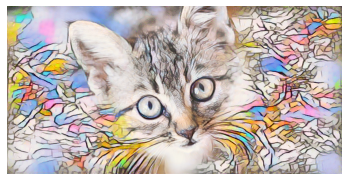

In [ ]:
# Plotting the final image
plt.imshow(scale_img(final_img))
plt.axis('off')
plt.show()

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(15,12),dpi=80) 
 
plt.figure(1)
plt.subplot(133)
plt.imshow(scale_img(final_img))
plt.axis('off')

plt.subplot(132)
plt.imshow(img2)
plt.axis('off')

plt.subplot(131)
plt.imshow(img)
plt.axis('off')


plt.show()